## Segment Soft Exudates

### UNET model

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

In [2]:
def load_data(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img) / 255.0  # Normalize the image between 0 and 1
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([up1, conv2], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([up2, conv1], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)  # Sigmoid for binary classification
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Dice Loss function
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

# Combined BCE and Dice Loss
def combined_bce_dice_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce_loss + d_loss

# using tf
def iou_metric(y_true, y_pred):
    # Convert predicted mask probabilities to binary (0 or 1)
    y_pred = tf.round(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

def dice_coefficient(y_true, y_pred):
    # Convert predicted mask probabilities to binary (0 or 1)
    y_pred = tf.round(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    return dice


In [3]:
model = unet_model(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss=combined_bce_dice_loss, metrics=['accuracy', iou_metric, dice_coefficient])

2024-10-22 11:57:16.994188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-22 11:57:16.995091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [5]:
# Directories for images and masks
image_dir = "path/to/augmented/dir/SEAugmented/Images"
mask_dir = "path/to/augmented/dir/SEAugmented/Masks"


# Image size (height, width, channels)
image_size = (256, 256)

all_images, all_masks = load_data(image_dir, mask_dir, image_size)

# Split into training and test sets (80% train, 20% test)
train_images, test_images, train_masks, test_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

# split train set into training and validation sets (90% train, 10% validation)
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)

In [6]:
len(all_images), len(all_masks)

(747, 747)

In [8]:
history = model.fit(train_images, train_masks, epochs=75,
                    batch_size=16, verbose=1, steps_per_epoch=len(train_images) // 16,
                    validation_data=(val_images, val_masks))

Epoch 1/75
33/33 [==============================] - ETA: 0s - loss: 1.0851 - accuracy: 0.9982 - iou_metric: 0.0000e+00 - dice_coefficient: 0.0000e+00

2024-10-22 11:58:39.161643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 51s 2s/step - loss: 1.0851 - accuracy: 0.9982 - iou_metric: 0.0000e+00 - dice_coefficient: 0.0000e+00 - val_loss: 1.0109 - val_accuracy: 0.9976 - val_iou_metric: 0.0000e+00 - val_dice_coefficient: 0.0000e+00
Epoch 2/75
33/33 [==============================] - 51s 2s/step - loss: 1.0097 - accuracy: 0.9982 - iou_metric: 0.0000e+00 - dice_coefficient: 0.0000e+00 - val_loss: 1.0099 - val_accuracy: 0.9976 - val_iou_metric: 0.0000e+00 - val_dice_coefficient: 0.0000e+00
Epoch 3/75
33/33 [==============================] - 40s 1s/step - loss: 1.0087 - accuracy: 0.9982 - iou_metric: 0.0000e+00 - dice_coefficient: 0.0000e+00 - val_loss: 1.0106 - val_accuracy: 0.9976 - val_iou_metric: 0.0000e+00 - val_dice_coefficient: 0.0000e+00
Epoch 4/75
33/33 [==============================] - 45s 1s/step - loss: 1.0077 - accuracy: 0.9981 - iou_metric: 0.0000e+00 - dice_coefficient: 0.0000e+00 - val_loss: 1.0077 - val_accuracy: 0.9976 - val_iou_metric: 0.0000e+00 - val_

In [9]:
scores = model.evaluate(val_images, val_masks)
print("Validation Loss: %.2f" % scores[0])
print("Validation Accuracy: %.2f%%" % (scores[1] * 100))
print("Validation IoU: %.2f%%" % (scores[2] * 100))
print("Validation Dice: %.2f%%" % (scores[3] * 100))

2/2 [==============================] - 2s 843ms/step - loss: 0.5421 - accuracy: 0.9978 - iou_metric: 0.3153 - dice_coefficient: 0.4793
Validation Loss: 0.54
Validation Accuracy: 99.78%
Validation IoU: 31.53%
Validation Dice: 47.93%


In [10]:
scores = model.evaluate(test_images, test_masks)
print("Test Loss: %.2f" % scores[0])
print("Test Accuracy: %.2f%%" % (scores[1] * 100))
print("Test IoU: %.2f%%" % (scores[2] * 100))
print("Test Dice: %.2f%%" % (scores[3] * 100))

5/5 [==============================] - 5s 848ms/step - loss: 0.5124 - accuracy: 0.9982 - iou_metric: 0.3437 - dice_coefficient: 0.5107
Test Loss: 0.51
Test Accuracy: 99.82%
Test IoU: 34.37%
Test Dice: 51.07%


## Visualise

1/1 [==============================] - 0s 49ms/step


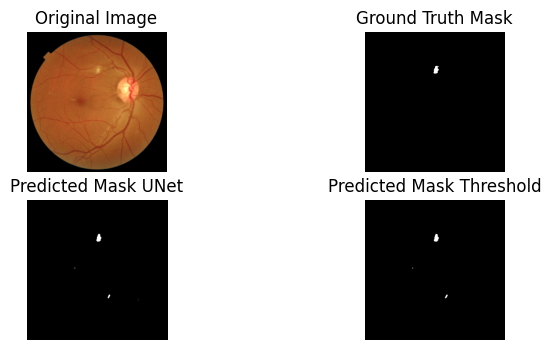

In [13]:
import matplotlib.pyplot as plt

image = all_images[234]  # Original test image
true_mask = all_masks[234]  # Ground truth mask

pred_mask_unet = model.predict(np.expand_dims(image, axis=0))  # Predict mask
pred_mask_unet_binary = (pred_mask_unet > 0.5).astype(int)  # Convert to binary

# pred_mask_resnet = model_resnet.predict(np.expand_dims(image, axis=0))  # Predict mask
# pred_mask_resnet_binary = (pred_mask_resnet > 0.5).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask_unet.squeeze(), cmap='gray')
plt.title("Predicted Mask UNet")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_unet_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')

plt.show()

## Save

In [14]:
# Save the model
model_json = model.to_json()
with open('../models_segmentation/SE.json', 'w') as json_file:
    json_file.write(model_json)

# Saving the model and weights
model.save_weights('../models_segmentation/SE.weights.h5')